In [ ]:
!huggingface-cli login

In [ ]:
pip install datasets

In [ ]:
pip install accelerate -U

In [ ]:
! pip install -U accelerate
! pip install -U transformers

In [ ]:
from datasets import load_dataset, load_metric
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, log_loss

In [ ]:
ds = load_dataset("imdb")

In [ ]:
ds

In [ ]:
ds['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)

    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    cm = confusion_matrix(labels, preds)

    fpr, tpr, _ = roc_curve(labels, pred.predictions[:, 1])
    roc_auc = auc(fpr, tpr)

    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    fpr_specificity = 1 - specificity

    logloss = log_loss(labels, pred.predictions)

    beta = 2
    f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

    mcc = (cm[0, 0] * cm[1, 1] - cm[0, 1] * cm[1, 0]) / np.sqrt((cm[0, 0] + cm[0, 1]) * (cm[0, 0] + cm[1, 0]) * (cm[1, 1] + cm[0, 1]) * (cm[1, 1] + cm[1, 0]))

    gmean = np.sqrt(recall * specificity)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'fpr': fpr_specificity,
        'log_loss': logloss,
        'f2_score': f2_score,
        'mcc': mcc,
        'gmean': gmean,
        'confusion_matrix': cm,
        'roc_auc': roc_auc
    }

In [ ]:
model_name = "google/electra-base-discriminator"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(examples):
    outputs = tokenizer(examples['text'], truncation=True)
    return outputs

tokenized_ds = ds.map(tokenize, batched=True)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(num_train_epochs=1,
                                  output_dir="distilbert-imdb",
                                  push_to_hub=True,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  evaluation_strategy="epoch")

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer)

In [ ]:
trainer = Trainer(model=model, tokenizer=tokenizer,
                  data_collator=data_collator,
                  args=training_args,
                  train_dataset=tokenized_ds["train"],
                  eval_dataset=tokenized_ds["test"],
                  compute_metrics=compute_metrics)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.196900,0.170706,0.939440


<ipython-input-12-0ee186c2f32d>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


TrainOutput(global_step=1563, training_loss=0.2529289803288338, metrics={'train_runtime': 3203.1891, 'train_samples_per_second': 7.805, 'train_steps_per_second': 0.488, 'total_flos': 6515172397265280.0, 'train_loss': 0.2529289803288338, 'epoch': 1.0})

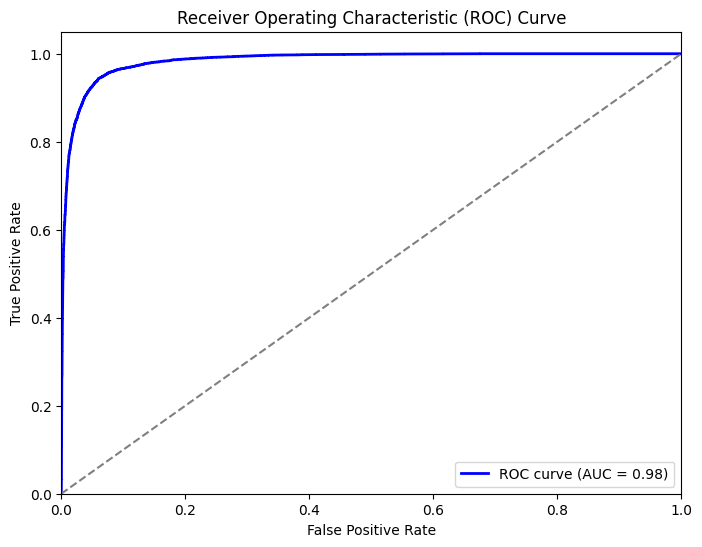

Trainer is attempting to log a value of "[[11836   664]
 [  850 11650]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [ ]:
results = trainer.evaluate()

In [ ]:
results

{'eval_loss': 0.1707061529159546,
 'eval_accuracy': 0.93944,
 'eval_precision': 0.9395373198919615,
 'eval_recall': 0.93944,
 'eval_f1': 0.9394366476004166,
 'eval_confusion_matrix': array([[11836,   664],
        [  850, 11650]]),
 'eval_roc_auc': 0.9840449792,
 'eval_runtime': 842.8004,
 'eval_samples_per_second': 29.663,
 'eval_steps_per_second': 1.855}